plt.stairs(list(df_hist_h['count']))

# Financial Data Analysis

We load the necessary modules and libraries. 

In [42]:
import pandas as pd
import pytz
import numpy as np
import matplotlib.text as text
import matplotlib.pyplot as plt
from datetime import datetime as dt, timedelta, time, date
from tiingo import TiingoClient


'\nclient = TiingoClient()\nhist = []\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-01-01\',endDate=\'2022-01-31\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-02-01\',endDate=\'2022-02-28\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-03-01\',endDate=\'2022-03-31\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-04-01\',endDate=\'2022-04-30\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-05-01\',endDate=\'2022-05-31\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-06-01\',endDate=\'2022-06-30\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-07-01\',endDate=\'2022-07-31\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-08-01\',endDate=\'2022-08-31\',frequency=\'1Min\'))\nhist.append(client.get_ticker_price("AGL",startDate=\'2022-09-01\

The following cell pulls the financial data from [Tiingo](https://www.tiingo.com/)

In [ ]:

"""
client = TiingoClient()
hist = []
hist.append(client.get_ticker_price("AGL",startDate='2022-01-01',endDate='2022-01-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-02-01',endDate='2022-02-28',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-03-01',endDate='2022-03-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-04-01',endDate='2022-04-30',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-05-01',endDate='2022-05-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-06-01',endDate='2022-06-30',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-07-01',endDate='2022-07-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-08-01',endDate='2022-08-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-09-01',endDate='2022-09-30',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-10-01',endDate='2022-10-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-11-01',endDate='2022-11-30',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2022-12-01',endDate='2022-12-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2023-01-01',endDate='2023-01-31',frequency='1Min'))
hist.append(client.get_ticker_price("AGL",startDate='2023-02-01',endDate='2023-02-13',frequency='1Min'))
for i, mon in enumerate(hist): 
    hist[i] = pd.DataFrame.from_dict(mon,orient='columns')
hist = pd.concat(hist,axis=0,ignore_index=True)
hist.to_csv('../data/history.csv',sep=',')

In [43]:
df = pd.read_csv('../data/history.csv',index_col=0,parse_dates=['date'])

In [44]:
eastern = pytz.timezone('US/Eastern')
#df['day'] = df['date'].map(lambda x: f"{x.year}-{x.month}-{x.day}")
df['day'] = df['date'].map(lambda x: date(x.year,x.month,x.day))
#df['time'] = df['date'].map(lambda x: f"{x.astimezone(eastern).hour}:{x.astimezone(eastern).minute}")
df['time'] = df['date'].map(lambda x: time(x.astimezone(eastern).hour,x.astimezone(eastern).minute))

In [45]:
vals_h = df.loc[df.groupby('day')['high'].idxmax()].sort_index()
vals_h = vals_h[vals_h['day'] >= date(2022,11,1)]
vals_h['period'] = vals_h['time'].map(lambda x: (60*x.hour+x.minute) // 30)
plot_vals_h = vals_h.groupby(['period'])['period'].count().reset_index(name='count')
#plot_vals_h['period'] = plot_vals_h['period'].astype('Int64')
plot_vals_h

,period,count
0,19,27
1,20,8
2,21,4
3,22,6
4,23,3
5,24,1
6,26,3
7,27,4
8,29,4
9,30,1


In [46]:
vals_l = df.loc[df.groupby('day')['low'].idxmin()].sort_index()
vals_l = vals_h[vals_h['day'] >= date(2022,11,1)]
vals_l['period'] = vals_l['time'].map(lambda x: (60*x.hour+x.minute) // 30)
plot_vals_l = vals_l.groupby(['period'])['period'].count().reset_index(name='count')
#plot_vals_l['period'] = plot_vals_l['period'].astype('Int64')
plot_vals_l

,period,count
0,19,27
1,20,8
2,21,4
3,22,6
4,23,3
5,24,1
6,26,3
7,27,4
8,29,4
9,30,1


In [47]:
periods = list(range(19,34))
bins = []
for i in periods:
    l_bound = time(i //2,30*(i % 2)).isoformat(timespec='minutes')
    r_bound = time((i+1) //2,30*((i+1) % 2)).isoformat(timespec='minutes')
    bins.append(l_bound+"-"+r_bound)
df_hist = pd.DataFrame({'period': periods,'bin': bins})
#df_hist['period'] = df_hist['period'].astype('Int64')
df_hist

,period,bin
0,19,09:30-10:00
1,20,10:00-10:30
2,21,10:30-11:00
3,22,11:00-11:30
4,23,11:30-12:00
5,24,12:00-12:30
6,25,12:30-13:00
7,26,13:00-13:30
8,27,13:30-14:00
9,28,14:00-14:30


In [48]:
df_hist_h = df_hist.merge(plot_vals_h,on='period',how='left').fillna(0)
df_hist_h['count'] = df_hist_h['count'].astype('Int64')
df_hist_h

,period,bin,count
0,19,09:30-10:00,27
1,20,10:00-10:30,8
2,21,10:30-11:00,4
3,22,11:00-11:30,6
4,23,11:30-12:00,3
5,24,12:00-12:30,1
6,25,12:30-13:00,0
7,26,13:00-13:30,3
8,27,13:30-14:00,4
9,28,14:00-14:30,0


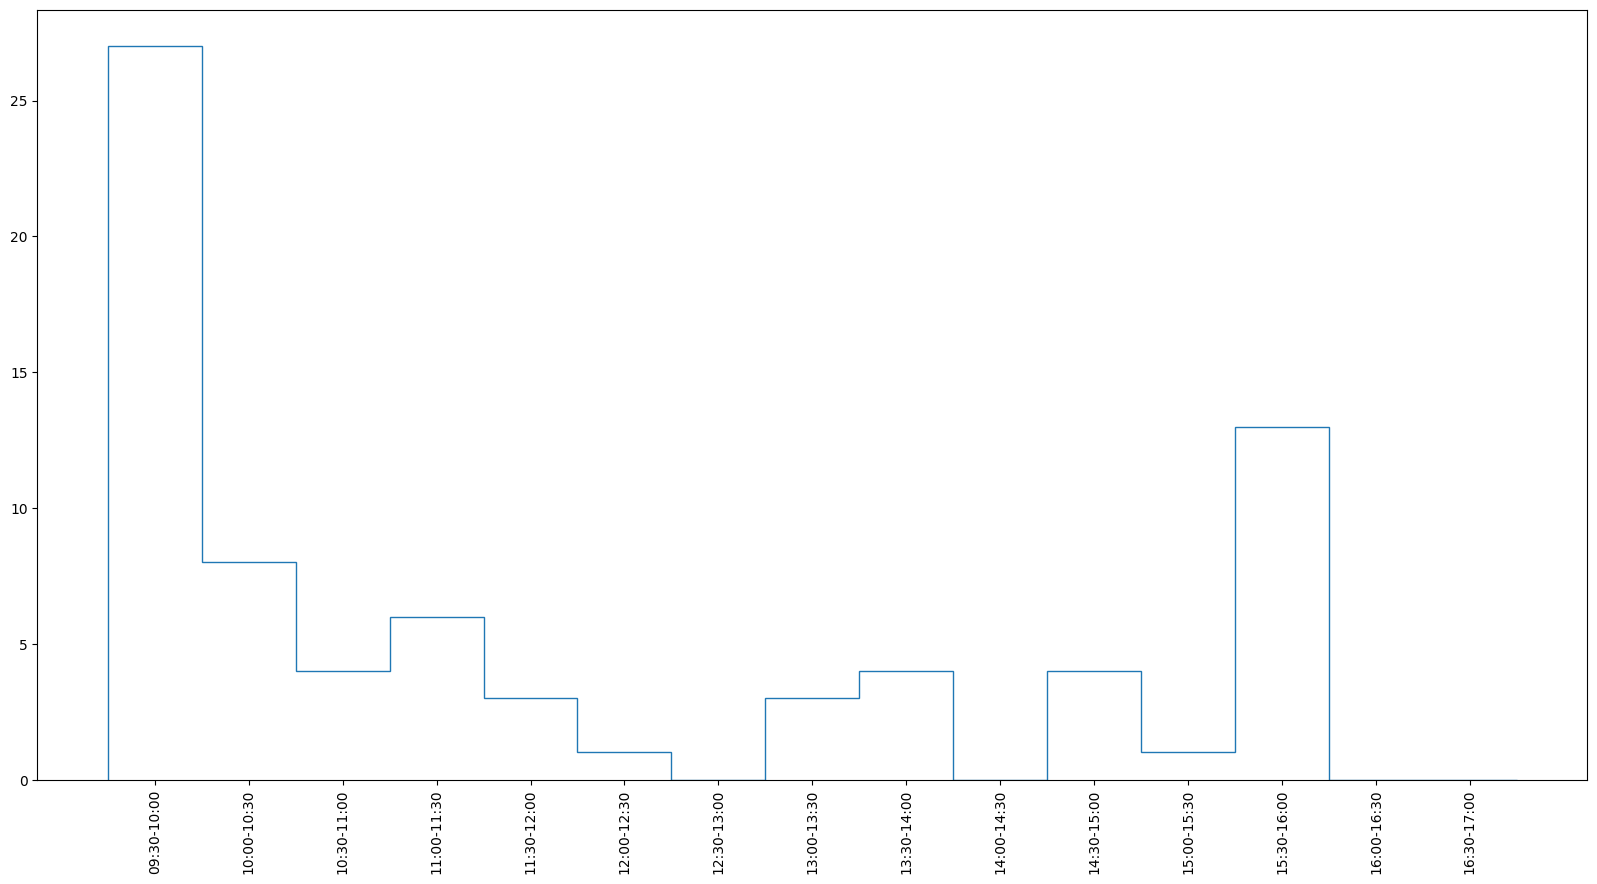

In [57]:
locs = list(df_hist_h['period'])
labels = list(df_hist_h['bin'])
labels
for i , x in enumerate(labels):
    labels[i] = text.Text(locs[i],0,labels[i])
labels
edges=[18.5]+[x+0.5 for x in list(df_hist_h['period'])]
plt.figure(figsize=(20,10))
plt.xticks(locs,labels)
plt.xticks(rotation=90)
plt.stairs(list(df_hist_h['count']),edges=edges)